# Classification of Diabetic Retinopathy with Deep Learning
---

A deep convolutional neural network based on [ResNet-34](https://arxiv.org/abs/1512.03385) to classify levels of diabetic retinopathy. 

The network has a sensitivity of 91.6 % and a specificity of 82.5 % for the binary task of classifying referable diabetic retinopathy. 

## Setup 

### Load libraries 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

I am using the excellent [fastai](https://github.com/fastai/fastai) library, which uses [PyTorch](http://pytorch.org/).

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
### Is this needed?
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

Check that CUDA and cuDNN are available:

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

## Data

The [Kaggle diabetic retinopathy](https://www.kaggle.com/c/diabetic-retinopathy-detection) dataset contains 35126 labelled images already organised into directories named according to the level of diabetic retinopathy (0,1,2,3 & 4). These numeric levels correspond to no diabetic retinopathy (0); mild retinopathy (1); moderate (2); severe (3) and proliferative (4).

### Validation set 
I created a validation set of 3512 (10 %) images by selecting images at random in a way that preserves the class ratios.

### Balance data
The dataset is unbalanced. The number of images in each class (after removal of the validation set images) is 23184 (class 0); 2189 (1); 4811 (2); 781 (3) and 649 (4). 

To balance the dataset, I created copies (symbolic links) of the images in the minority classes (1,2,3 and 4) so that these classes each contained approximately 5000 images. I didn't fully balance the dataset as the number of images (5 * 23184) would have been too large to train in a reasonable time.

As the model is trained on augmented images this duplication should not present too much of an issue as the network never sees the same image twice.

Path to the data. I use `/dev/shm` for speed.

In [6]:
PATH = "/dev/shm/data/retinopathy/"

## Model

In [7]:
arch = resnet34
image_size = 512
batch_size = 32

### Data augmentation
Centre crop with 10-20 % random zoom; random rotatation of up to $10^\circ$. Random left-right flip. 50 % of images are slightly blurred.

In [8]:
min_size = int(1.1 * image_size)
aug_tfms=[RandomRotate(10, p=1.0), 
          RandomBlur([3,5], probability=0.5),
          RandomScale(sz=min_size, max_zoom=1.1, p=1.0),
          RandomFlip()]
tfms = tfms_from_model(arch, sz=image_size, aug_tfms=aug_tfms, crop_type=CropType.CENTER)

### Setup model 

In [9]:
# Choose num_workers according to the number of CPU cores.
data = ImageClassifierData.from_paths(PATH, bs=batch_size, tfms=tfms, num_workers=16)
p_dropout = [0.4, 0.7]
learn = ConvLearner.pretrained(arch, data, ps=p_dropout, precompute=False)

## Learning rate
A relatively high learning rate of 0.1 was found to work well.

In [10]:
lr = 1e-1

## Train last layers 

Train the last layers with cosine annealing. (Note that fastai's default metric of accuracy is not the best choice for an unbalanced classification task. Better metrics are used later on).

In [11]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      1.126905   0.816475   0.742992  
    1      1.083118   0.791961   0.745833                     
    2      1.071215   0.793367   0.745265                     
    3      1.072228   0.783937   0.741667                     
    4      1.053596   0.765592   0.748958                     
    5      1.04541    0.777031   0.746117                     
    6      1.052934   0.773506   0.745833                      


## Train whole model 

Train the whole model with differential learning rates: a lower learning rate for the first layers, higher for the middle layers and higher still for the last layers.  

In [12]:
# Unfreeze the model to allow training of all layers
learn.unfreeze()

In [13]:
lrs = [lr/9, lr/3, lr]

In [14]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                      
    0      0.536409   0.554196   0.823295  
    1      0.639725   0.566161   0.82017                       
    2      0.488599   0.540165   0.827367                      
    3      0.743436   0.644611   0.779735                      
    4      0.57691    0.566614   0.826515                      
    5      0.457763   0.532606   0.833523                      
    6      0.430851   0.548231   0.831345                      


## Model performance 

### Test time augmentation
Use test time augmentation to improve predictions. 

In [15]:
# Use four augmentations
log_preds, y = learn.TTA(n_aug=4)

# Average over the augmentations
probs = np.mean(np.exp(log_preds), axis=0)
preds = np.argmax(probs, axis=1)

### Confusion matrix 

[[2552   43   28    2    1]
 [ 178   54   22    0    0]
 [ 129   51  254   37   10]
 [   2    3   34   47    6]
 [   6    1   15    9   28]]


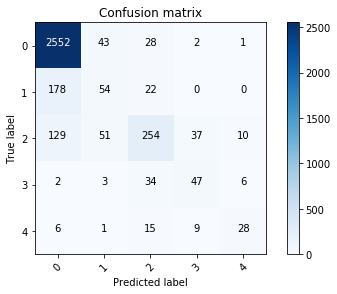

In [16]:
plot_confusion_matrix(confusion_matrix(y, preds), classes=data.classes);

The model really excels at not mistaking cases of mild (1) or no (1) retinopathy for severe forms: only 0.1 % of these cases are predicted to be severe (3) or proliferative (4) — see top right of the confusion matrix. The model also does well in the other corner: 92 % of severe (3) and proliferative (4) cases are predicted to be moderate or worse.

The model is less good at identifying moderate (2) cases, often mistaking these for other levels. Mild (1) and no (0) cases are also often mistaken for moderate (2).

### Referable diabetic retinopathy

We can group the five classes of retinopathy into 'referable' (moderate or worse retinopathy) and 'non-referable' (mild or no retinopathy) and look at the ROC curve for this binary classification.

In [17]:
# Split off referable retinopathy (classes 2,3 & 4) and recombine with stack
# e.g. want [0.1,0.2,0.2,0.3,0.2] -> [0.1+0.2, 0.2+0.3+0.2] = [0.3, 0.7]
p_non_referable = np.sum(probs[:,0:2], axis=1)
p_referable = np.sum(probs[:,2:], axis=1)
probs_referable = np.stack([p_non_referable, p_referrable], axis=1)

In [18]:
# Do the same for the true and predicted labels
y_referable = 1*(y >= 2)
y_referable_preds = np.argmax(probs_referable, axis=1)

In [19]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_referable, probs_referable[:,1], pos_label=1)
auc = roc_auc_score(y_referable, probs_referable[:,1])

In [20]:
# Two points selected for high specificity and high sensitivity by examining the tpr and fpr arrays.
idx = [209, 275]

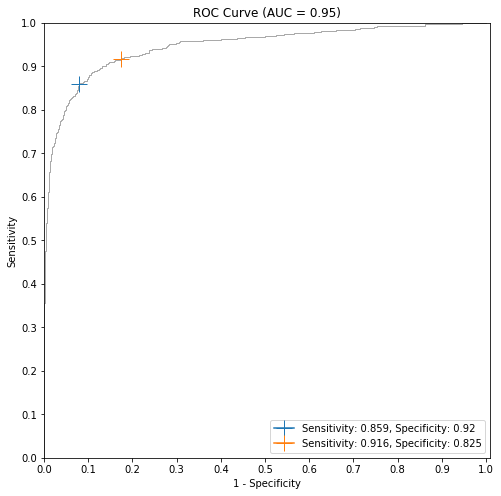

In [21]:
# Plot ROC curve
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='darkgray', lw=1)
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.0])
plt.xticks(np.linspace(0,1,11))
plt.yticks(np.linspace(0,1,11))
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
for i in idx:
    plt.plot(fpr[i], tpr[i], marker='+', markersize=16, 
             label=f'Sensitivity: {tpr[i]:.3}, Specificity: {1-fpr[i]:.3}')
#plt.plot(fpr[275], tpr[275], marker='+', color='g', markersize=16, label='blah')
plt.title(f'ROC Curve (AUC = {auc:.2})')
plt.legend(loc='lower right');

## Conclusion
For just a few lines of code we have a model that performs resonably well. Deeper networks e.g. ResNet networks with more layers and larger image sizes are likely to improve performance. However, I would like to try an attentional-based model next (e.g. like https://arxiv.org/pdf/1704.03549). 

Much of the difference between the levels of retionpathy is in the fine detail (blood vessels, aneurysms, etc.). A model that identifies regions of interest in the retinal image and feeds these regions to a CNN that has been trained on the fine detail could well improve on classification performance. It may also be faster to train as fewer of the pixels need to be passed through the CNN.

---